In [9]:
# import the necessary packages
import pandas as pd
from scipy.signal import butter, lfilter, resample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc
import torch
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import os

from dataloaders.VTT_dataloader import DataSet_VTT
from model_train.preprocess import DataPreprocess
from models.TinyHAREncoderDecoder import TinyHAR_Encoder_Decoder_Model

pd.options.display.float_format = '{:.2f}'.format

In [10]:

reference_point = "shoulder"
window_size = 25
step_size = 5
imu_position = "hand"
learning_rate = 0.001
batch_size = 32
num_epochs = 100
loss_function = "mse"

pd.options.display.float_format = '{:.2f}'.format

# check if cuda is available
print(torch.cuda.is_available())
torch.autograd.set_detect_anomaly(True)

data_path = '../data/VTT_ConIot_Dataset'
IMU_path = data_path + '/IMU'
Keypoint_path = data_path + '/Keypoint'
activities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
users = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
num_input_features = 36
num_output_features = 3

True


In [11]:
preprocess = DataPreprocess(reference_point, window_size, step_size, imu_position)
# get the processed data
keypoint_data, imu_data, sliding_windows = preprocess.processed_data()

# replace any nan value as the mean of the value before and after it
keypoint_data = keypoint_data.fillna(keypoint_data.mean())
# count the number of nan values in the imu data
print(imu_data.isnull().sum())

imu_data = imu_data.fillna(imu_data.mean())



Keypoint file for Subject_06_Task_11 does not exist
hand_Ax_g    1500
hand_Ay_g    1500
hand_Az_g    1500
activity        0
subject         0
dtype: int64


In [12]:
print(keypoint_data.shape)
print(imu_data.shape)

(286100, 38)
(286100, 5)


In [ ]:
#filter the data with a bandpass filter, 0.5Hz to 20Hz, frequency is 400Hz
from scipy import signal
from scipy.signal import butter, freqz, filtfilt

def lowpass_filter(data, low_cut_off=1, fs=q5):
    b, a = butter(4, low_cut_off, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y

C:\Users\Azhar\AppData\Local\Temp\ipykernel_19128\448946147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_window['mag' + str(i)] = np.sqrt(single_window['x' + str(i)]**2 + single_window['y' + str(i)]**2)


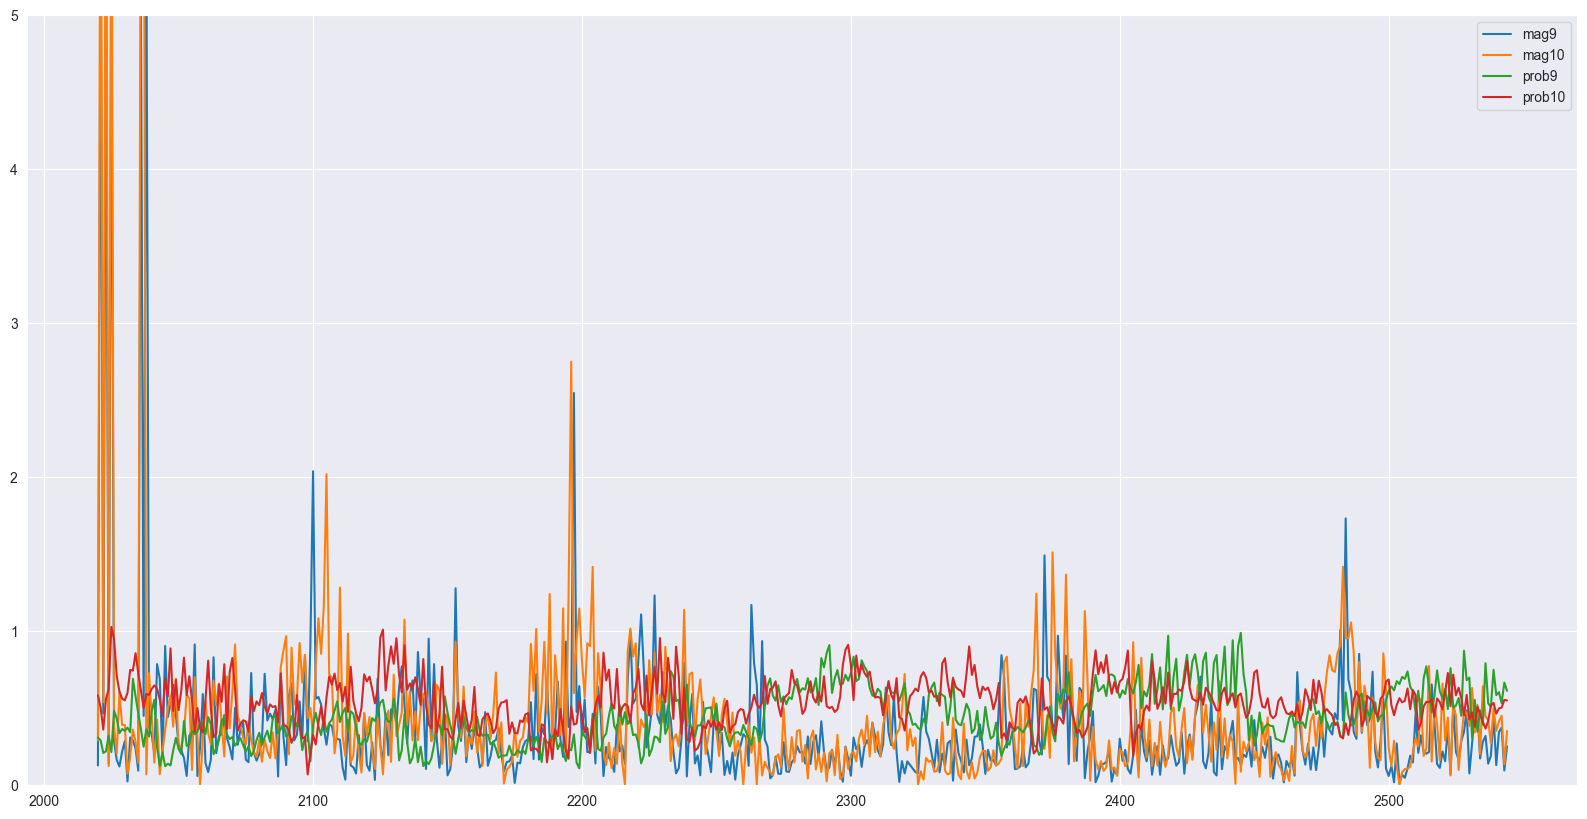

C:\Users\Azhar\AppData\Local\Temp\ipykernel_19128\448946147.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_for_window['mag'] = np.sqrt(imu_for_window['hand_Ax_g']**2 + imu_for_window['hand_Ay_g']**2 + imu_for_window['hand_Az_g']**2)


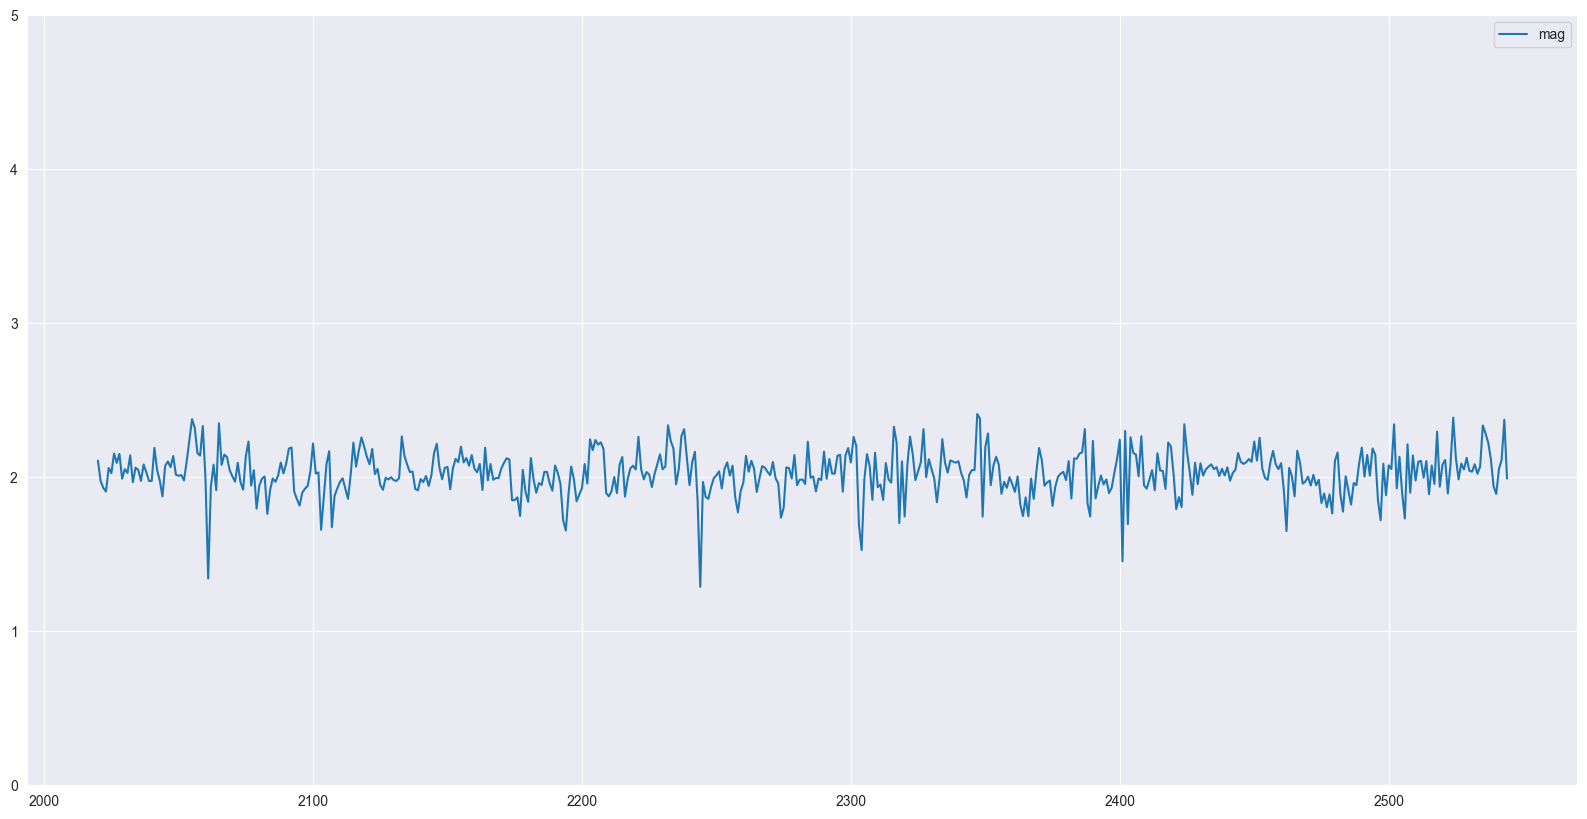

In [15]:
first_window = sliding_windows.iloc[400]
second_window = sliding_windows.iloc[500]
single_window = keypoint_data.iloc[first_window['start']:second_window['end'] + 1]
for i in range(5,17):
    single_window['mag' + str(i)] = np.sqrt(single_window['x' + str(i)]**2 + single_window['y' + str(i)]**2)
    # drop x and y
    single_window = single_window.drop(['x' + str(i), 'y' + str(i)], axis=1)

# plot the single window
plt.figure(figsize=(20, 10))
# set y lim to 0 to 5
plt.ylim(0, 5)

plt.plot(single_window['mag9'], label='mag9')
plt.plot(single_window['mag10'], label='mag10')
plt.plot(single_window['prob9'], label='prob9')
plt.plot(single_window['prob10'], label='prob10')

plt.legend()
plt.show()

imu_for_window = imu_data.iloc[first_window['start']:second_window['end'] + 1]
imu_for_window['mag'] = np.sqrt(imu_for_window['hand_Ax_g']**2 + imu_for_window['hand_Ay_g']**2 + imu_for_window['hand_Az_g']**2)
plt.figure(figsize=(20, 10))
plt.ylim(0, 5)
plt.plot(imu_for_window['mag'], label='mag')
plt.legend()

In [27]:
#
# dataset_train = DataSet_VTT(keypoint_data, imu_data, sliding_windows, 1, flag='train')
#
# train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
#
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_size = (window_size, num_input_features)
# output_size = (window_size, num_output_features)
# model = TinyHAR_Encoder_Decoder_Model(input_size, 5)
# model = model.double().cuda()
# if loss_function == 'cross_entropy':
#     criterion = nn.CrossEntropyLoss(reduction="mean").to(device)
# else:
#     criterion = nn.MSELoss(reduction="mean").to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_size = (window_size, num_input_features)
# output_size = (window_size, num_output_features)
# model = EncoderDecoder(input_size, output_size)
# model = model.double().cuda()
# if loss_function == 'cross_entropy':
#     criterion = nn.CrossEntropyLoss(reduction="mean").to(device)
# else:
#     criterion = nn.MSELoss(reduction="mean").to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#
# for epoch in range(num_epochs):
#     print(f'Epoch: {epoch}')
#     for i, data in enumerate(train_loader):
#         keypoint, imu = data
#         keypoint = keypoint.double().to(device)
#         # check if keypoint has any nan values
#         # print(torch.isnan(keypoint).any())
#         imu = imu.double().to(device)
#         output = model(keypoint)
#         output = output.squeeze(1)
#         loss = criterion(output, imu)
#
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if i % 100 == 0:
#             print(f'Epoch: {epoch}, Loss: {loss.item()}')

